In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns
import pandas as pd
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp

dataframes = dict()
metrics = dict()

def wasserstein(x,y,versions,data):
    ws = []
    for version in versions:
        wsd = wasserstein_distance(
            np.array(data[version]["Samples"][x]).ravel(),
            np.array(data[version]["Samples"][y]).ravel()
        )
        ws.append(wsd)
    return ws, np.min(ws), np.max(ws), np.mean(ws), np.std(ws)

def kolmogorov_smirnov(x,y,versions,data):
    ks = []
    for version in versions:
        kss, _ = ks_2samp(
            np.array(data[version]["Samples"][x]).ravel(),
            np.array(data[version]["Samples"][y]).ravel()
        )
        ks.append(kss)
    return ks, np.min(ks), np.max(ks), np.mean(ks), np.std(ks)

for file in os.listdir("../evaluated/"):
    df = pd.DataFrame()
    # Parse experiment name
    name = "E"
    if "representative" in file:
        name += "R"
    name += file.split("-")[-1].replace(".json","").replace("m","")
    print("Evaluating", name)
    # Load data
    with open("../evaluated/"+file,"r") as fp:
        data = json.load(fp)
    # Calculate KS / WS for Generative vs Target/Empiric and Empiric vs Target
    versions = sorted(list(data), key=lambda x: int(x))
    df["Wiederholung"] = versions
    ws, ws_min, ws_max, ws_mean, ws_std = wasserstein("generator", "data", versions, data)
    ks, ks_min, ks_max, ks_mean, ks_std = kolmogorov_smirnov("generator", "data", versions, data)

    ws_emp, ws_emp_min, ws_emp_max, ws_emp_mean, ws_emp_std = wasserstein("generator", "empiric", versions, data)
    ks_emp, ks_emp_min, ks_emp_max, ks_emp_mean, ks_emp_std = kolmogorov_smirnov("generator", "empiric", versions, data)

    ws_emp_d, ws_emp_d_min, ws_emp_d_max, ws_emp_d_mean, ws_emp_d_std = wasserstein("empiric", "data", versions, data)
    ks_emp_d, ks_emp_d_min, ks_emp_d_max, ks_emp_d_mean, ks_emp_d_std = kolmogorov_smirnov("empiric", "data", versions, data)

    df["Kolmogorov-Smirnov (Generiert, Ziel)"] = ks
    df["Wasserstein (Generiert, Ziel)"] = ws

    df["Kolmogorov-Smirnov (Generiert, Trainingsdaten)"] = ks_emp
    df["Wasserstein (Generiert, Trainingsdaten)"] = ws_emp

    df["Kolmogorov-Smirnov (Trainingsdaten, Ziel)"] = ks_emp_d
    df["Wasserstein (Trainingsdaten, Ziel)"] = ws_emp_d

    metrics[name] = dict(
        ks_min = ks_min, ks_max = ks_max, ks_mean = ks_mean, ks_std = ks_std,
        ws_min = ws_min, ws_max = ws_max, ws_mean = ws_mean, ws_std = ws_std,

        ks_emp_min = ks_emp_min, ks_emp_max = ks_emp_max, ks_emp_mean = ks_emp_mean, ks_emp_std = ks_emp_std,
        ws_emp_min = ws_emp_min, ws_emp_max = ws_emp_max, ws_emp_mean = ws_emp_mean, ws_emp_std = ws_emp_std,

        ks_emp_d_min = ks_emp_d_min, ks_emp_d_max = ks_emp_d_max, ks_emp_d_mean = ks_emp_d_mean, ks_emp_d_std = ks_emp_d_std,
        ws_emp_d_min = ws_emp_d_min, ws_emp_d_max = ws_emp_d_max, ws_emp_d_mean = ws_emp_d_mean, ws_emp_d_std = ws_emp_d_std,
    )
    dataframes[name] = df

# Parse the Metrics into Dataframes
metric_df = pd.DataFrame()
metric_df["Experiment"] = list(metrics)
metric_df["Minimum"] = [metrics[name]["ks_min"] for name in metrics]
metric_df["Durchschnitt"] = [metrics[name]["ks_mean"] for name in metrics]
metric_df["Maximum"] = [metrics[name]["ks_max"] for name in metrics]
metric_df["Standardabweichung"] = [metrics[name]["ks_std"] for name in metrics]
dataframes["KS-Statistik (Gen, Ziel)"] = metric_df

metric_df = pd.DataFrame()
metric_df["Experiment"] = list(metrics)
metric_df["Minimum"] = [metrics[name]["ws_min"] for name in metrics]
metric_df["Durchschnitt"] = [metrics[name]["ws_mean"] for name in metrics]
metric_df["Maximum"] = [metrics[name]["ws_max"] for name in metrics]
metric_df["Standardabweichung"] = [metrics[name]["ws_std"] for name in metrics]
dataframes["Wasserstein (Gen, Ziel)"] = metric_df

metric_df = pd.DataFrame()
metric_df["Experiment"] = list(metrics)
metric_df["Minimum"] = [metrics[name]["ks_emp_min"] for name in metrics]
metric_df["Durchschnitt"] = [metrics[name]["ks_emp_mean"] for name in metrics]
metric_df["Maximum"] = [metrics[name]["ks_emp_max"] for name in metrics]
metric_df["Standardabweichung"] = [metrics[name]["ks_emp_std"] for name in metrics]
dataframes["KS-Statistik (Gen, Training)"] = metric_df

metric_df = pd.DataFrame()
metric_df["Experiment"] = list(metrics)
metric_df["Minimum"] = [metrics[name]["ws_emp_d_min"] for name in metrics]
metric_df["Durchschnitt"] = [metrics[name]["ws_emp_d_mean"] for name in metrics]
metric_df["Maximum"] = [metrics[name]["ws_emp_d_max"] for name in metrics]
metric_df["Standardabweichung"] = [metrics[name]["ws_emp_d_std"] for name in metrics]
dataframes["Wasserstein (Gen, Training)"] = metric_df

metric_df = pd.DataFrame()
metric_df["Experiment"] = list(metrics)
metric_df["Minimum"] = [metrics[name]["ks_emp_d_min"] for name in metrics]
metric_df["Durchschnitt"] = [metrics[name]["ks_emp_d_mean"] for name in metrics]
metric_df["Maximum"] = [metrics[name]["ks_emp_d_max"] for name in metrics]
metric_df["Standardabweichung"] = [metrics[name]["ks_emp_d_std"] for name in metrics]
dataframes["KS-Statistik (Training, Ziel)"] = metric_df

metric_df = pd.DataFrame()
metric_df["Experiment"] = list(metrics)
metric_df["Minimum"] = [metrics[name]["ws_emp_d_min"] for name in metrics]
metric_df["Durchschnitt"] = [metrics[name]["ws_emp_d_mean"] for name in metrics]
metric_df["Maximum"] = [metrics[name]["ws_emp_d_max"] for name in metrics]
metric_df["Standardabweichung"] = [metrics[name]["ws_emp_d_std"] for name in metrics]
dataframes["Wasserstein (Training, Ziel)"] = metric_df

print(list(dataframes))

Evaluating E100
Evaluating E25
Evaluating E50
Evaluating E500
Evaluating E75
Evaluating ER100
Evaluating ER25
Evaluating ER50
Evaluating ER500
Evaluating ER75
['E100', 'E25', 'E50', 'E500', 'E75', 'ER100', 'ER25', 'ER50', 'ER500', 'ER75', 'KS-Statistik (Gen, Ziel)', 'Wasserstein (Gen, Ziel)', 'KS-Statistik (Gen, Training)', 'Wasserstein (Gen, Training)', 'KS-Statistik (Training, Ziel)', 'Wasserstein (Training, Ziel)']


In [7]:
%matplotlib inline

## E R 25 vs. E X

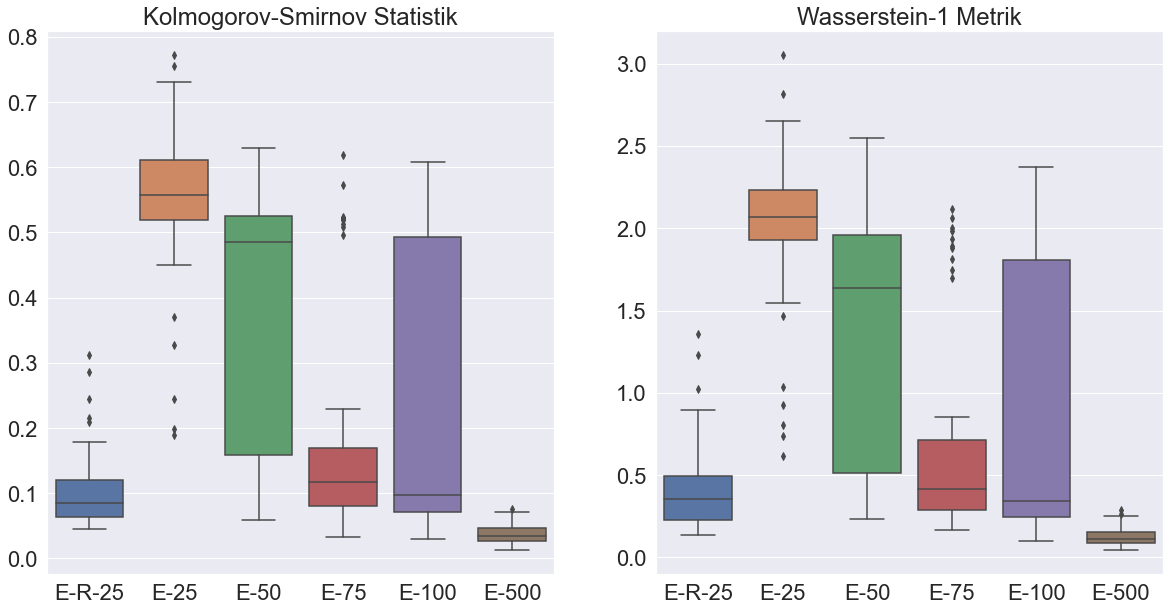

In [5]:
er25_data_ks = pd.DataFrame()
er25_data_ks["E-R-25"] = dataframes["ER25"]["Kolmogorov-Smirnov (Generiert, Ziel)"]
er25_data_ks["E-25"] = dataframes["E25"]["Kolmogorov-Smirnov (Generiert, Ziel)"]
er25_data_ks["E-50"] = dataframes["E50"]["Kolmogorov-Smirnov (Generiert, Ziel)"]
er25_data_ks["E-75"] = dataframes["E75"]["Kolmogorov-Smirnov (Generiert, Ziel)"]
er25_data_ks["E-100"] = dataframes["E100"]["Kolmogorov-Smirnov (Generiert, Ziel)"]
er25_data_ks["E-500"] = dataframes["E500"]["Kolmogorov-Smirnov (Generiert, Ziel)"]

er25_data_ws = pd.DataFrame()
er25_data_ws["E-R-25"] = dataframes["ER25"]["Wasserstein (Generiert, Ziel)"]
er25_data_ws["E-25"] = dataframes["E25"]["Wasserstein (Generiert, Ziel)"]
er25_data_ws["E-50"] = dataframes["E50"]["Wasserstein (Generiert, Ziel)"]
er25_data_ws["E-75"] = dataframes["E75"]["Wasserstein (Generiert, Ziel)"]
er25_data_ws["E-100"] = dataframes["E100"]["Wasserstein (Generiert, Ziel)"]
er25_data_ws["E-500"] = dataframes["E500"]["Wasserstein (Generiert, Ziel)"]

plt.figure(figsize=(20,10))
sns.set(font_scale = 2)
plt.subplot(1,2,1)
plt.title("Kolmogorov-Smirnov Statistik")
sns.boxplot(data=er25_data_ks)
plt.subplot(1,2,2)
plt.title("Wasserstein-1 Metrik")
sns.boxplot(data=er25_data_ws)
plt.savefig("ER25.png")
plt.show()

## ER50 vs EX

In [6]:
er25_data_ks = pd.DataFrame()
er25_data_ks["E-R-50"] = dataframes["ER50"]["Kolmogorov-Smirnov (Generiert, Ziel)"]
er25_data_ks["E-25"] = dataframes["E25"]["Kolmogorov-Smirnov (Generiert, Ziel)"]
er25_data_ks["E-50"] = dataframes["E50"]["Kolmogorov-Smirnov (Generiert, Ziel)"]
er25_data_ks["E-75"] = dataframes["E75"]["Kolmogorov-Smirnov (Generiert, Ziel)"]
er25_data_ks["E-100"] = dataframes["E100"]["Kolmogorov-Smirnov (Generiert, Ziel)"]
er25_data_ks["E-500"] = dataframes["E500"]["Kolmogorov-Smirnov (Generiert, Ziel)"]

er25_data_ws = pd.DataFrame()
er25_data_ws["E-R-50"] = dataframes["ER50"]["Wasserstein (Generiert, Ziel)"]
er25_data_ws["E-25"] = dataframes["E25"]["Wasserstein (Generiert, Ziel)"]
er25_data_ws["E-50"] = dataframes["E50"]["Wasserstein (Generiert, Ziel)"]
er25_data_ws["E-75"] = dataframes["E75"]["Wasserstein (Generiert, Ziel)"]
er25_data_ws["E-100"] = dataframes["E100"]["Wasserstein (Generiert, Ziel)"]
er25_data_ws["E-500"] = dataframes["E500"]["Wasserstein (Generiert, Ziel)"]

plt.figure(figsize=(20,10))
sns.set(font_scale = 2)
plt.subplot(1,2,1)
plt.title("Kolmogorov-Smirnov Statistik")
sns.boxplot(data=er25_data_ks)
plt.subplot(1,2,2)
plt.title("Wasserstein-1 Metrik")
sns.boxplot(data=er25_data_ws)
plt.savefig("ER50.png")
plt.show()

## Plot über Anzahl

In [14]:
list(metrics["E25"])

['ks_min',
 'ks_max',
 'ks_mean',
 'ks_std',
 'ws_min',
 'ws_max',
 'ws_mean',
 'ws_std',
 'ks_emp_min',
 'ks_emp_max',
 'ks_emp_mean',
 'ks_emp_std',
 'ws_emp_min',
 'ws_emp_max',
 'ws_emp_mean',
 'ws_emp_std',
 'ks_emp_d_min',
 'ks_emp_d_max',
 'ks_emp_d_mean',
 'ks_emp_d_std',
 'ws_emp_d_min',
 'ws_emp_d_max',
 'ws_emp_d_mean',
 'ws_emp_d_std']

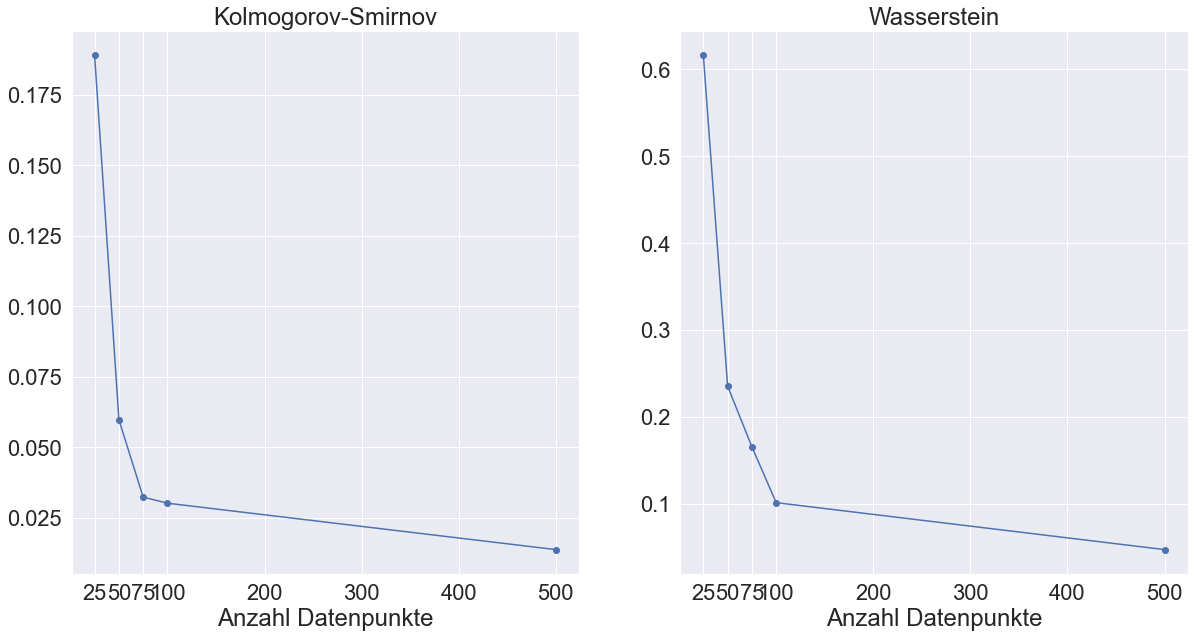

In [7]:
ks_daten = [metrics[experiment]["ks_min"] for experiment in sorted(list(metrics), key = lambda x: int(x.replace("R","").replace("E",""))) if "R" not in experiment]
ws_daten = [metrics[experiment]["ws_min"] for experiment in sorted(list(metrics), key = lambda x: int(x.replace("R","").replace("E",""))) if "R" not in experiment]
plt.figure(figsize=(20,10))
sns.set(font_scale = 2)
plt.subplot(1,2,1)
plt.title("Kolmogorov-Smirnov")
plt.plot([25,50,75,100,500], ks_daten, marker="o")
plt.xticks([25,50,75,100,200,300,400,500])
plt.xlabel("Anzahl Datenpunkte")
plt.subplot(1,2,2)
plt.title("Wasserstein")
plt.plot([25,50,75,100,500], ws_daten, marker="o")
plt.xticks([25,50,75,100,200,300,400,500])
plt.xlabel("Anzahl Datenpunkte")
plt.savefig("experimente-zufall.png")
plt.show()

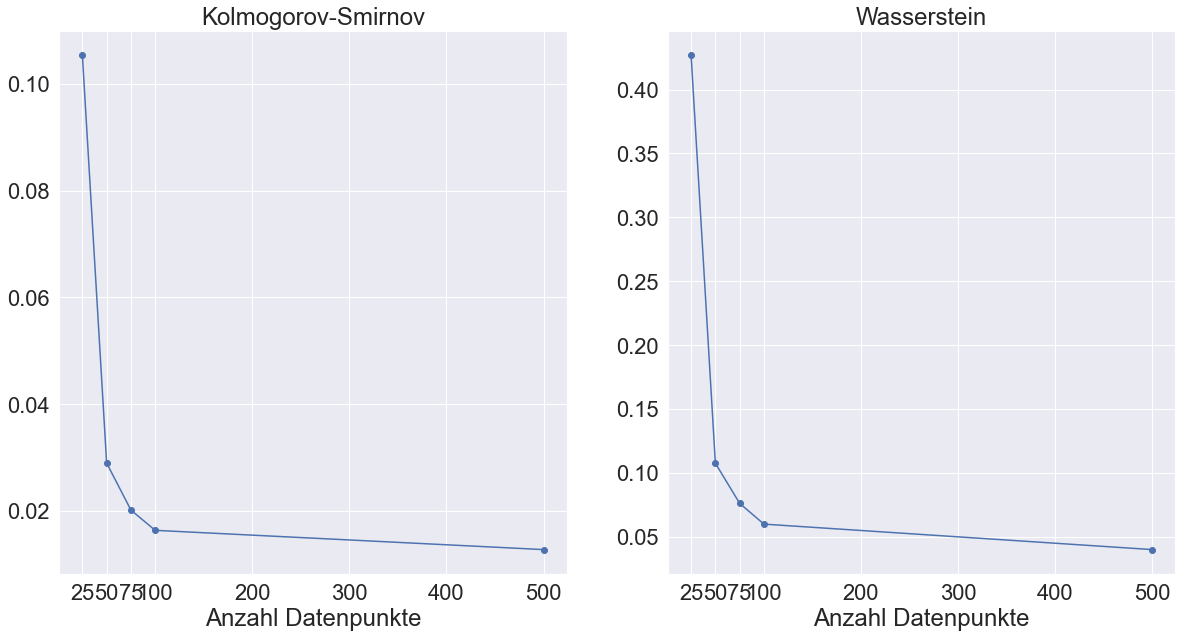

In [8]:
ks_daten = [metrics[experiment]["ks_mean"] for experiment in sorted(list(metrics), key = lambda x: int(x.replace("R","").replace("E",""))) if "R" in experiment]
ws_daten = [metrics[experiment]["ws_mean"] for experiment in sorted(list(metrics), key = lambda x: int(x.replace("R","").replace("E",""))) if "R" in experiment]
plt.figure(figsize=(20,10))
sns.set(font_scale = 2)
plt.subplot(1,2,1)
plt.title("Kolmogorov-Smirnov")
plt.plot([25,50,75,100,500], ks_daten, marker="o")
plt.xticks([25,50,75,100,200,300,400,500])
plt.xlabel("Anzahl Datenpunkte")
plt.subplot(1,2,2)
plt.title("Wasserstein")
plt.plot([25,50,75,100,500], ws_daten, marker="o")
plt.xticks([25,50,75,100,200,300,400,500])
plt.xlabel("Anzahl Datenpunkte")
plt.savefig("experimente-representative.png")
plt.show()

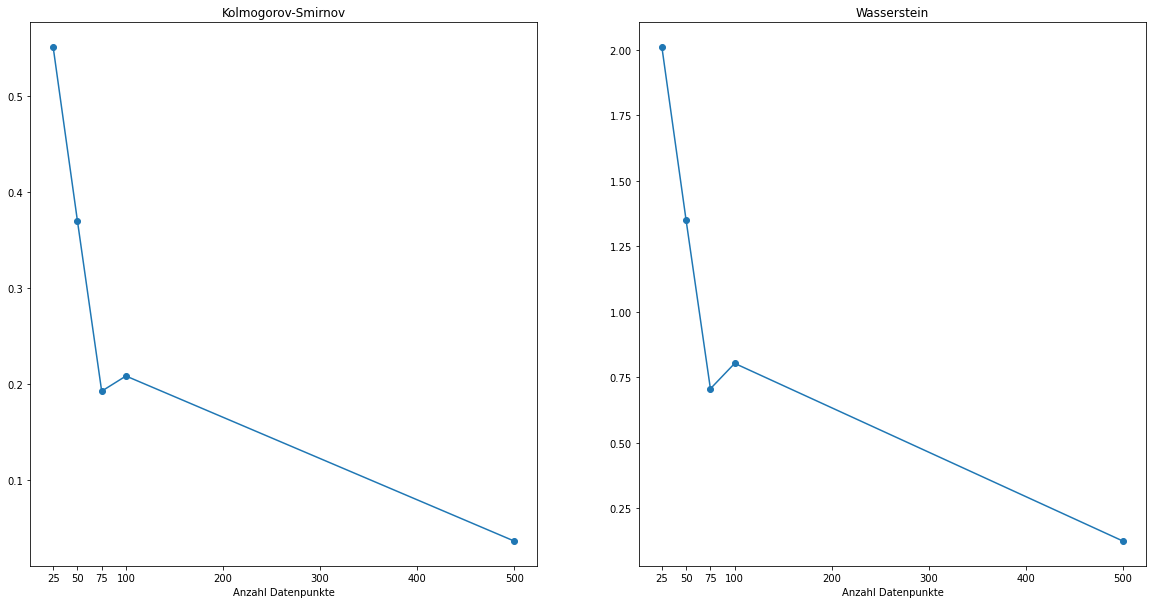

In [39]:
ks_daten = [metrics[experiment]["ks_mean"] for experiment in sorted(list(metrics), key = lambda x: int(x.replace("R","").replace("E",""))) if "R" not in experiment]
ws_daten = [metrics[experiment]["ws_mean"] for experiment in sorted(list(metrics), key = lambda x: int(x.replace("R","").replace("E",""))) if "R" not in experiment]
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title("Kolmogorov-Smirnov")
plt.plot([25,50,75,100,500], ks_daten, marker="o")
plt.xticks([25,50,75,100,200,300,400,500])
plt.xlabel("Anzahl Datenpunkte")
plt.subplot(1,2,2)
plt.title("Wasserstein")
plt.plot([25,50,75,100,500], ws_daten, marker="o")
plt.xticks([25,50,75,100,200,300,400,500])
plt.xlabel("Anzahl Datenpunkte")
plt.savefig("experimente-zufall.png")
plt.show()